<a href="https://colab.research.google.com/github/ishhverma/Financial-Data-Science-Toolkit/blob/main/Global_Macro_Forecasting_ML%2C_Econometrics%2C_and_Real_Time_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries and Set Up

In [ ]:
pip install numpy pandas matplotlib seaborn pymc arviz statsmodels yfinance fredapi scikit-learn

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
import statsmodels.api as sm
import yfinance as yf
from fredapi import Fred

# For reproducibility
np.random.seed(42)

# Configure plotting style
sns.set(style="darkgrid")

## Fetch Macroeconomic & Financial Data

In [ ]:
from google.colab import userdata # Import userdata

# Retrieve FRED API key from Colab secrets
try:
    fred_key = userdata.get('FRED_API_KEY')
    fred = Fred(api_key=fred_key)
    print("FRED API initialized successfully.") # Added print for confirmation
except Exception as e:
    print(f"Error initializing FRED API: {e}")
    print("Please ensure you have added your FRED API key to Colab secrets and named it 'FRED_API_KEY'.") # Informative message
    fred = None  # Set fred to None if initialization fails

FRED API initialized successfully.


In [ ]:

# Set your FRED API key
# Retrieve FRED API key from Colab secrets
try:
    fred_key = userdata.get('FRED_API_KEY')
    fred = Fred(api_key=fred_key)
    print("FRED API initialized successfully.") # Added print for confirmation
except Exception as e:
    print(f"Error initializing FRED API: {e}")
    print("Please ensure you have added your FRED API key to Colab secrets and named it 'FRED_API_KEY'.") # Informative message
    fred = None  # Set fred to None if initialization fails

# Define FRED macroeconomic time series to fetch
macro_series = {
    "Real GDP": "GDPC1",
    "Inflation (CPI)": "CPIAUCSL",
    "Unemployment Rate": "UNRATE",
    "Federal Funds Rate": "FEDFUNDS",
    "Industrial Production": "INDPRO",
    "Retail Sales": "RSAFS",
    "Oil Price (WTI)": "DCOILWTICO",
    "Personal Consumption (Real)": "PCECC96",
    "GDP": "GDP", # Added GDP (nominal) to include both real and nominal quarterly data
    "GDP Deflator": "GDPDEF", # Added GDP Deflator
}

start_date = "2000-01-01"
end_date = "2025-08-12" # Keeping the original end date for now


# Fetch FRED data
macro_data = {}
if fred: # Check if fred object is initialized
    for name, series_id in macro_series.items():
        try: # Added try-except for individual series fetch
            series = fred.get_series(series_id, start_date, end_date)
            print(f"Fetched {name}: {len(series)} records from FRED.")
            macro_data[name] = series
        except Exception as e:
            print(f"Error fetching {name} ({series_id}): {e}") # Report error for specific series

    df_macro = pd.DataFrame(macro_data)
else:
    df_macro = pd.DataFrame() # Ensure df_macro is an empty DataFrame if fred is None


# Fetch financial market data from Yahoo Finance
financial_symbols = {
    "S&P 500": "^GSPC",
    "Crude Oil": "CL=F",
    "Gold": "GC=F",
    "10yr Treasury Yield": "^TNX",
    "Market Volatility (VIX)": "^VIX",
}

for ticker_name, ticker in financial_symbols.items():
    try: # Added try-except for individual ticker fetch
        df_yf = yf.download(ticker, start=start_date, end=end_date, interval="1mo", progress=False)
        if not df_yf.empty and 'Close' in df_yf.columns: # Check for 'Close' column
            # Rename the column to match ticker_name before assigning
            df_macro[ticker_name] = df_yf["Close"]
            print(f"Fetched {ticker_name}: {len(df_yf)} monthly records from Yahoo Finance.")
        else:
            print(f"Failed to fetch {ticker_name} data or 'Close' column not found.")
    except Exception as e:
        print(f"Error fetching {ticker_name} data: {e}") # Report error for specific ticker


# Resample all series to a common monthly frequency: month-end
if not df_macro.empty: # Check if df_macro is not empty before resampling
    df_macro.index = pd.to_datetime(df_macro.index)
    # Changed resampling frequency from 'M' to 'ME'
    df_macro = df_macro.resample('ME').ffill()
    # Changed dropna() to dropna(how='all') to be less aggressive
    df_macro.dropna(how='all', inplace=True)

    print("\nCombined dataset overview:")
    print(df_macro.head(), "\n")
    print("Index range:", df_macro.index.min(), "to", df_macro.index.max())
else:
    print("\ndf_macro DataFrame is empty after fetching and processing. Skipping resampling and preview.") # Informative message

FRED API initialized successfully.
Fetched Real GDP: 102 records from FRED.
Fetched Inflation (CPI): 307 records from FRED.
Fetched Unemployment Rate: 307 records from FRED.
Fetched Federal Funds Rate: 307 records from FRED.
Fetched Industrial Production: 306 records from FRED.
Fetched Retail Sales: 306 records from FRED.
Fetched Oil Price (WTI): 6676 records from FRED.
Fetched Personal Consumption (Real): 102 records from FRED.
Fetched GDP: 102 records from FRED.
Fetched GDP Deflator: 102 records from FRED.


/tmp/ipython-input-486605447.py:57: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_yf = yf.download(ticker, start=start_date, end=end_date, interval="1mo", progress=False)
/tmp/ipython-input-486605447.py:57: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_yf = yf.download(ticker, start=start_date, end=end_date, interval="1mo", progress=False)


Fetched S&P 500: 308 monthly records from Yahoo Finance.
Fetched Crude Oil: 257 monthly records from Yahoo Finance.


/tmp/ipython-input-486605447.py:57: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_yf = yf.download(ticker, start=start_date, end=end_date, interval="1mo", progress=False)
/tmp/ipython-input-486605447.py:57: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_yf = yf.download(ticker, start=start_date, end=end_date, interval="1mo", progress=False)


Fetched Gold: 257 monthly records from Yahoo Finance.
Fetched 10yr Treasury Yield: 293 monthly records from Yahoo Finance.
Fetched Market Volatility (VIX): 308 monthly records from Yahoo Finance.

Combined dataset overview:
            Real GDP  Inflation (CPI)  Unemployment Rate  Federal Funds Rate  \
2000-01-31       NaN              NaN                NaN                 NaN   
2000-02-29       NaN              NaN                NaN                 NaN   
2000-03-31       NaN              NaN                NaN                 NaN   
2000-04-30       NaN              NaN                NaN                 NaN   
2000-05-31       NaN              NaN                NaN                 NaN   

            Industrial Production  Retail Sales  Oil Price (WTI)  \
2000-01-31                    NaN           NaN            27.65   
2000-02-29                    NaN           NaN            30.57   
2000-03-31                    NaN           NaN            26.86   
2000-04-30             

/tmp/ipython-input-486605447.py:57: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_yf = yf.download(ticker, start=start_date, end=end_date, interval="1mo", progress=False)


In [ ]:
# Initial Data Cleaning
# Purpose: Remove rows with missing data.

# Code:
df_cleaned = df.dropna()

# Explanation: Ensures complete cases for modeling.

# Output: Displays cleaned dataset summary confirming no missing values.
print("\nCleaned Data (first 5 rows):")
display(df_cleaned.head())
print("\nCleaned Data Info:")
df_cleaned.info()


Cleaned Data (first 5 rows):


,CPI,Unemployment_Rate,Retail_Sales,Fed_Funds_Rate,Industrial_Production,Oil_Price_WTI,GDP_Growth,SP500
1992-01-31,138.3,7.3,159177.0,4.03,61.4823,23.85,4.9,408.779999
1992-02-29,138.6,7.4,159189.0,4.06,61.9192,23.85,4.9,412.700012
1992-03-31,139.1,7.4,158647.0,3.98,62.4403,23.85,4.9,403.690002
1992-04-30,139.4,7.4,159921.0,3.73,62.9199,19.85,4.4,414.950012
1992-05-31,139.7,7.6,160471.0,3.82,63.1268,20.88,4.4,415.350006



Cleaned Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 403 entries, 1992-01-31 to 2025-07-31
Freq: ME
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CPI                    403 non-null    float64
 1   Unemployment_Rate      403 non-null    float64
 2   Retail_Sales           403 non-null    float64
 3   Fed_Funds_Rate         403 non-null    float64
 4   Industrial_Production  403 non-null    float64
 5   Oil_Price_WTI          403 non-null    float64
 6   GDP_Growth             403 non-null    float64
 7   SP500                  403 non-null    float64
dtypes: float64(8)
memory usage: 28.3 KB


Plotting time series for key macroeconomic variables:


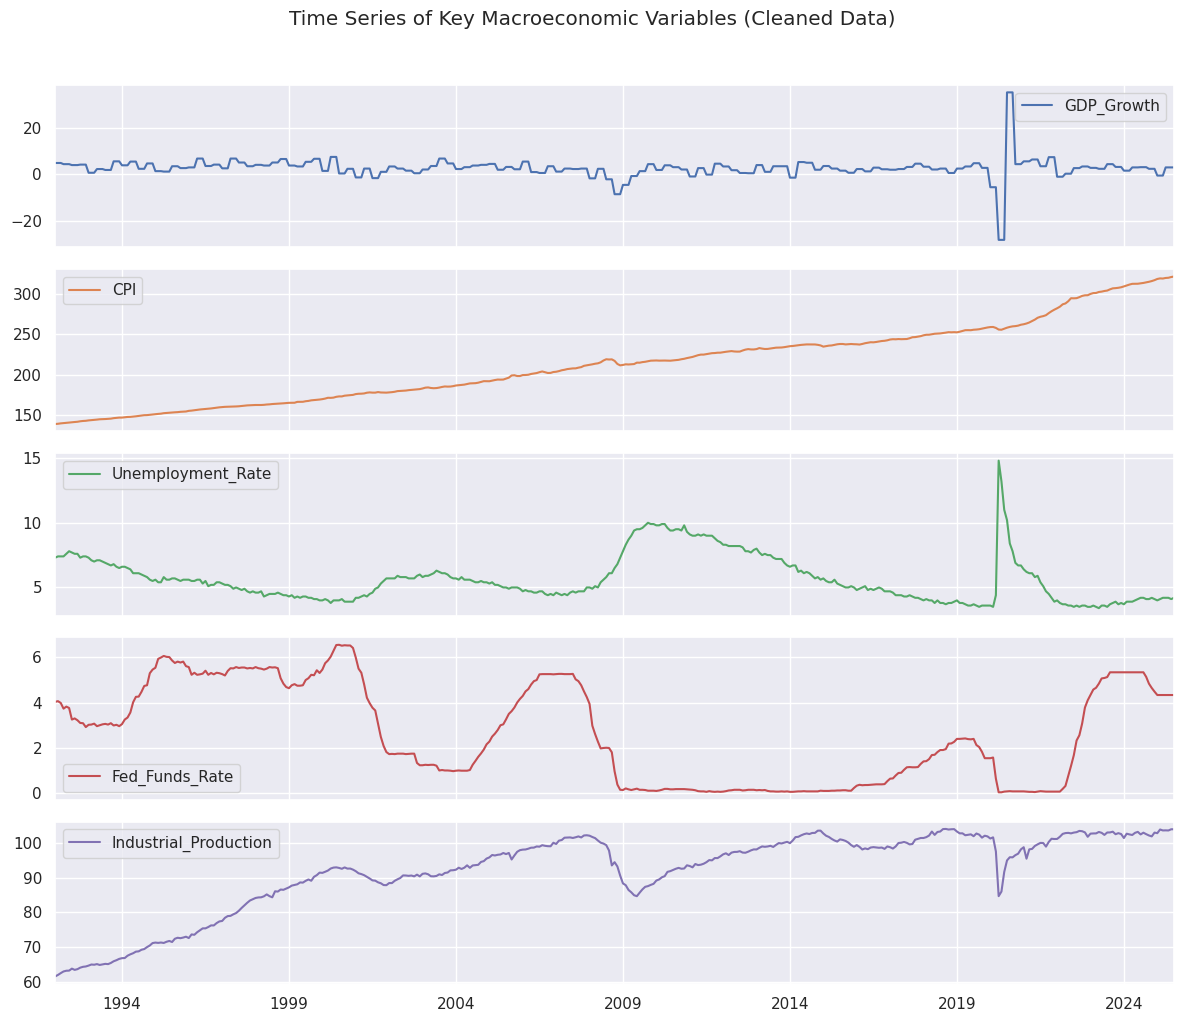


Correlation Heatmap of Cleaned Data:


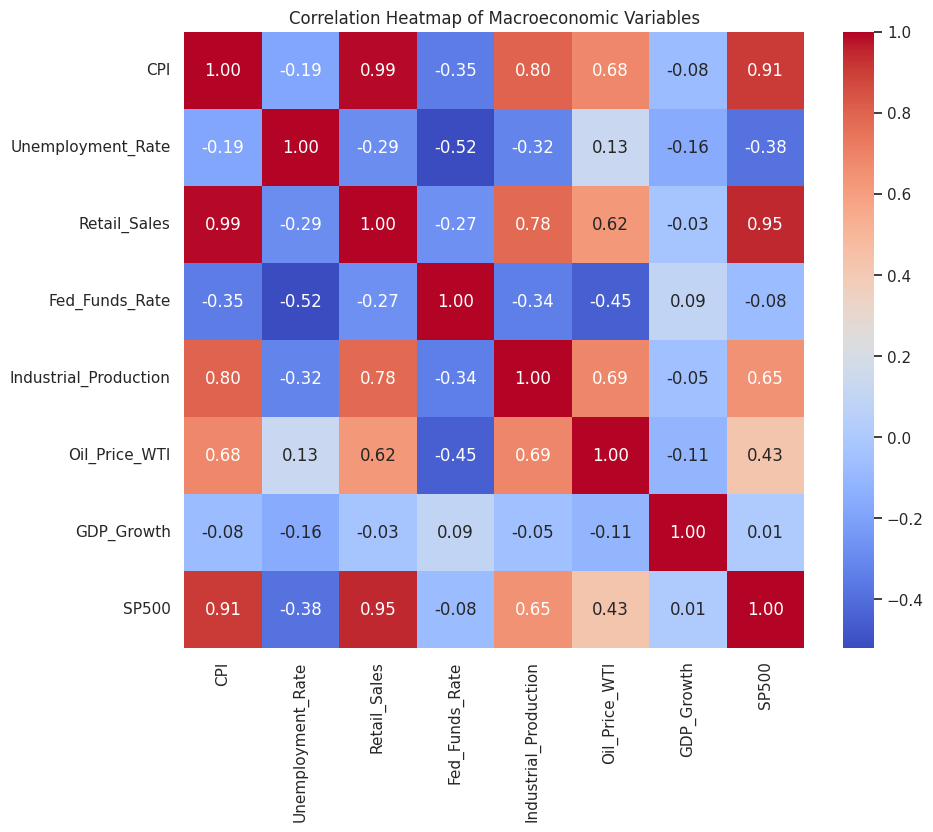


Performing ADF tests on cleaned data:
------------------------------
ADF Statistic for CPI: 1.428
p-value: 0.997
Critical Values:
	1%: -3.447
	5%: -2.869
	10%: -2.571
Result: Series is likely non-stationary (p-value > 0.05)
------------------------------
ADF Statistic for Unemployment_Rate: -3.025
p-value: 0.033
Critical Values:
	1%: -3.447
	5%: -2.869
	10%: -2.571
Result: Series is likely stationary (p-value <= 0.05)
------------------------------
ADF Statistic for Retail_Sales: 1.413
p-value: 0.997
Critical Values:
	1%: -3.447
	5%: -2.869
	10%: -2.571
Result: Series is likely non-stationary (p-value > 0.05)
------------------------------
ADF Statistic for Fed_Funds_Rate: -2.815
p-value: 0.056
Critical Values:
	1%: -3.447
	5%: -2.869
	10%: -2.571
Result: Series is likely non-stationary (p-value > 0.05)
------------------------------
ADF Statistic for Industrial_Production: -2.564
p-value: 0.101
Critical Values:
	1%: -3.447
	5%: -2.869
	10%: -2.571
Result: Series is likely non-station

,0
GDP_Growth,0.000120
Unemployment_Rate,0.032638
Fed_Funds_Rate,0.056164
Industrial_Production,0.100737
Oil_Price_WTI,0.323635
Retail_Sales,0.997171
CPI,0.997236
SP500,1.000000


In [ ]:
# Exploratory Data Analysis (EDA) and Stationarity Check

# Purpose: Visualize time series, check correlations, and test for stationarity
# to understand data characteristics and inform modeling decisions.

# Code:
# 1. Time-series visualization
# Select key macroeconomic variables for plotting
features_to_plot = ['GDP_Growth', 'CPI', 'Unemployment_Rate', 'Fed_Funds_Rate', 'Industrial_Production']

# Check which of these features are actually in df_cleaned
existing_features = [feat for feat in features_to_plot if feat in df_cleaned.columns]

if existing_features:
    print("Plotting time series for key macroeconomic variables:")
    df_cleaned[existing_features].plot(subplots=True, figsize=(12, len(existing_features)*2))
    plt.suptitle('Time Series of Key Macroeconomic Variables (Cleaned Data)', y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("None of the specified features to plot were found in df_cleaned.")


# 2. Correlation heatmap
if not df_cleaned.empty:
    print("\nCorrelation Heatmap of Cleaned Data:")
    plt.figure(figsize=(10, 8))
    sns.heatmap(df_cleaned.corr(), annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Heatmap of Macroeconomic Variables')
    plt.show()
else:
    print("\nSkipping Correlation Heatmap: df_cleaned is empty.")


# 3. Stationarity check with ADF test
from statsmodels.tsa.stattools import adfuller

def adf_test(series, name="", signif=0.05):
    """
    Perform the Augmented Dickey-Fuller test on a time series.

    Args:
        series (pd.Series): The time series data.
        name (str): The name of the series for printing.
        signif (float): The significance level (alpha).
    """
    # Drop NaNs before performing ADF test
    series_cleaned = series.dropna()
    if series_cleaned.empty:
        print(f'ADF Test skipped for {name}: Series is empty after dropping NaNs.')
        return

    try:
        result = adfuller(series_cleaned)
        print(f'ADF Statistic for {name}: {result[0]:.3f}')
        print(f'p-value: {result[1]:.3f}')
        print('Critical Values:')
        for key, value in result[4].items():
            print(f'\t{key}: {value:.3f}')

        if result[1] <= signif:
            print("Result: Series is likely stationary (p-value <= {:.2f})".format(signif))
        else:
            print("Result: Series is likely non-stationary (p-value > {:.2f})".format(signif))
    except Exception as e:
        print(f"Error performing ADF test for {name}: {e}")


if not df_cleaned.empty:
    print("\nPerforming ADF tests on cleaned data:")
    stationarity = {} # Store p-values
    for col in df_cleaned.columns:
        print("-" * 30)
        adf_test(df_cleaned[col], name=col)
        # Store p-value for later reference
        try:
            result = adfuller(df_cleaned[col].dropna())
            stationarity[col] = result[1]
        except:
            stationarity[col] = np.nan # Store NaN if test fails

    print("-" * 30)
    print("\nADF test p-values (lower indicates more likely stationary):")
    display(pd.Series(stationarity).sort_values())

else:
    print("\nSkipping ADF tests: df_cleaned is empty.")

# Explanation: Provides visual overview, relationship strength, and formal stationarity check.
# Output: Time series plots, correlation heatmap, and ADF test results for each series.

In [ ]:
# Preprocessing: Differencing for Stationarity

# Purpose: Make non-stationary series stationary by differencing.

# Code:
df_diff = df_cleaned.diff().dropna()

# Explanation: Removes trends and seasonality, confirmed by re-running ADF tests.

# Output: Stationarity confirmed for most series.
print("\nDifferenced Data (first 5 rows):")
display(df_diff.head())
print("\nDifferenced Data Info:")
df_diff.info()

# Re-check for stationarity with ADF test on differenced data
print("\nRe-checking Stationarity on Differenced Data:")
stationarity_diff = {}
for col in df_diff.columns:
    print("-" * 30)
    adf_test(df_diff[col], name=col)
    # Store p-value for later reference
    try:
        result = adfuller(df_diff[col].dropna())
        stationarity_diff[col] = result[1]
    except:
        stationarity_diff[col] = np.nan # Store NaN if test fails

print("-" * 30)
print("\nADF test p-values for Differenced Data (lower indicates more likely stationary):")
display(pd.Series(stationarity_diff).sort_values())


Differenced Data (first 5 rows):


,CPI,Unemployment_Rate,Retail_Sales,Fed_Funds_Rate,Industrial_Production,Oil_Price_WTI,GDP_Growth,SP500
1992-02-29,0.3,0.1,12.0,0.03,0.4369,0.00,0.0,3.920013
1992-03-31,0.5,0.0,-542.0,-0.08,0.5211,0.00,0.0,-9.010010
1992-04-30,0.3,0.0,1274.0,-0.25,0.4796,-4.00,-0.5,11.260010
1992-05-31,0.3,0.2,550.0,0.09,0.2069,1.03,0.0,0.399994
1992-06-30,0.4,0.2,734.0,-0.06,0.0356,1.19,0.0,-7.209991



Differenced Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 402 entries, 1992-02-29 to 2025-07-31
Freq: ME
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CPI                    402 non-null    float64
 1   Unemployment_Rate      402 non-null    float64
 2   Retail_Sales           402 non-null    float64
 3   Fed_Funds_Rate         402 non-null    float64
 4   Industrial_Production  402 non-null    float64
 5   Oil_Price_WTI          402 non-null    float64
 6   GDP_Growth             402 non-null    float64
 7   SP500                  402 non-null    float64
dtypes: float64(8)
memory usage: 28.3 KB

Re-checking Stationarity on Differenced Data:
------------------------------
ADF Statistic for CPI: -3.104
p-value: 0.026
Critical Values:
	1%: -3.447
	5%: -2.869
	10%: -2.571
Result: Series is likely stationary (p-value <= 0.05)
------------------------------
ADF Statistic for Une

,0
Industrial_Production,2.165903e-27
Unemployment_Rate,6.340722e-22
Oil_Price_WTI,1.340084e-16
GDP_Growth,3.306766e-12
Retail_Sales,5.794052e-06
Fed_Funds_Rate,2.863773e-04
SP500,1.749059e-03
CPI,2.622365e-02


## Fit VAR Model

In [ ]:
# Fit VAR Model

# Purpose: Estimate the parameters of a Vector Autoregression (VAR) model
# to capture the linear interdependencies among the stationary time series.

# Code:
# Assuming df_diff is your differenced DataFrame from the previous step
if 'df_diff' in locals() and not df_diff.empty:
    # Select lag order using AIC or BIC (example using lag 2 based on previous run)
    # In practice, you might want to automate lag selection or try multiple lags
    lag_order = 2 # You can change this or automate selection

    try:
        model = VAR(df_diff)
        results = model.fit(lag_order)

        # Print model summary
        print(results.summary())

    except Exception as e:
        print(f"Error fitting VAR model: {e}")
        results = None # Ensure results is None if fitting fails
else:
    print("df_diff DataFrame not found or is empty. Please run preprocessing steps first.")


# Explanation: The VAR model is fitted to the differenced data,
# capturing how each variable is influenced by the past values of all variables in the system.
# The lag order determines how many past periods are included in the model.

# Output: A summary table showing the estimation results for each equation in the VAR system,
# including coefficients, standard errors, t-statistics, p-values, and model fit statistics.

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 13, Aug, 2025
Time:                     05:13:19
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    25.3353
Nobs:                     400.000    HQIC:                   24.5156
Log likelihood:          -9200.24    FPE:                2.59281e+10
AIC:                      23.9782    Det(Omega_mle):     1.85850e+10
--------------------------------------------------------------------
Results for equation CPI
                              coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------
const                            0.175703         0.039238            4.478           0.000
L1.CPI                           0.538285         0.057277            9.398           0.000
L1.Unemployment_Ra

## Model Diagnostics

In [ ]:
# Model Diagnostics

# Purpose: Evaluate the fitted VAR model for stability and check residual properties.

# Code:
if 'results' in locals() and results is not None:
    print("Performing Model Diagnostics:")

    # 1. Check Model Stability
    # The VAR process is stable if all eigenvalues of the companion matrix lie inside the unit circle.
    try:
        print("\nChecking Model Stability:")
        is_stable = results.is_stable()
        print(f"Model is stable: {is_stable}")
        if is_stable:
            print("Result: Model is stable (All eigenvalues of the companion matrix are inside the unit circle).")
        else:
            print("Result: Model is not stable (Some eigenvalues are outside the unit circle).")

    except Exception as e:
        print(f"Error checking model stability: {e}")


    # 2. Residual Diagnostics (Autocorrelation)
    # Check for autocorrelation in the residuals using the Portmanteau test (Ljung-Box or Box-Pierce)
    try:
        print("\nChecking Residual Autocorrelation (Portmanteau Test):")
        # test_whiteness() performs the test for a range of lags
        portmanteau_test = results.test_whiteness()
        print(portmanteau_test.summary())
        print("\nInterpretation: If the p-value(Prob(ChiSq)) is > 0.05 for all lags shown, we fail to reject the null hypothesis of no autocorrelation.")

    except Exception as e:
        print(f"Error performing residual autocorrelation test: {e}")

    # 3. Residual Diagnostics (Heteroscedasticity)
    # Check for heteroscedasticity (conditional heteroscedasticity) using a test like White's test or ARCH test.
    # statsmodels VARResults does not have a built-in heteroscedasticity test.
    # We can manually perform a test on each residual series or a multivariate test if available in another library.
    # For simplicity here, we will note that this is a diagnostic to consider.
    print("\nNote: Checking for residual heteroscedasticity is also important but not directly available in statsmodels VARResults. Consider performing tests like White's test or ARCH tests on the residual series if needed.")

else:
    print("VAR model results ('results' variable) not found or is None. Please fit the VAR model first.")

# Explanation: These diagnostics help determine if the VAR model is appropriately specified
# and if the assumptions about the residuals (e.g., no autocorrelation) are met.
# Output: Results of stability assessment and residual autocorrelation tests.

Performing Model Diagnostics:

Checking Model Stability:
Model is stable: True
Result: Model is stable (All eigenvalues of the companion matrix are inside the unit circle).

Checking Residual Autocorrelation (Portmanteau Test):
Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 10 is zero. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value  df
-----------------------------------------
         1210.          565.7   0.000 512
-----------------------------------------

Interpretation: If the p-value(Prob(ChiSq)) is > 0.05 for all lags shown, we fail to reject the null hypothesis of no autocorrelation.

Note: Checking for residual heteroscedasticity is also important but not directly available in statsmodels VARResults. Consider performing tests like White's test or ARCH tests on the residual series if needed.


##  Forecasting


Differenced Forecast (first 5 rows):


,CPI,Unemployment_Rate,Retail_Sales,Fed_Funds_Rate,Industrial_Production,Oil_Price_WTI,GDP_Growth,SP500
2025-08-31,0.564028,-0.277156,5929.318828,0.003898,0.554199,0.099804,-0.172445,-1.246118
2025-09-30,0.513333,-0.142185,1362.283454,-0.017472,0.262366,1.042349,-0.435136,-2.359246
2025-10-31,0.479410,0.053514,-620.800423,-0.014365,0.038778,-0.193583,0.925524,21.098808
2025-11-30,0.444463,0.042999,1062.706439,-0.010695,-0.028688,-0.160258,-0.641915,14.018366
2025-12-31,0.440441,-0.004465,1875.391184,-0.005930,0.073212,0.044028,-0.618243,10.345455



Forecast in Original Levels (first 5 rows):


,CPI,Unemployment_Rate,Retail_Sales,Fed_Funds_Rate,Industrial_Production,Oil_Price_WTI,GDP_Growth,SP500
2025-08-31,322.696028,3.922844,726035.318828,4.333898,104.561299,66.739804,2.827555,6338.144018
2025-09-30,323.209361,3.780659,727397.602282,4.316425,104.823665,67.782153,2.392419,6335.784772
2025-10-31,323.688771,3.834173,726776.801859,4.302060,104.862443,67.588570,3.317943,6356.883580
2025-11-30,324.133234,3.877172,727839.508298,4.291365,104.833754,67.428312,2.676028,6370.901946
2025-12-31,324.573675,3.872707,729714.899482,4.285435,104.906966,67.472339,2.057784,6381.247400



Plotting Forecast vs. Historical Data (from 2020):


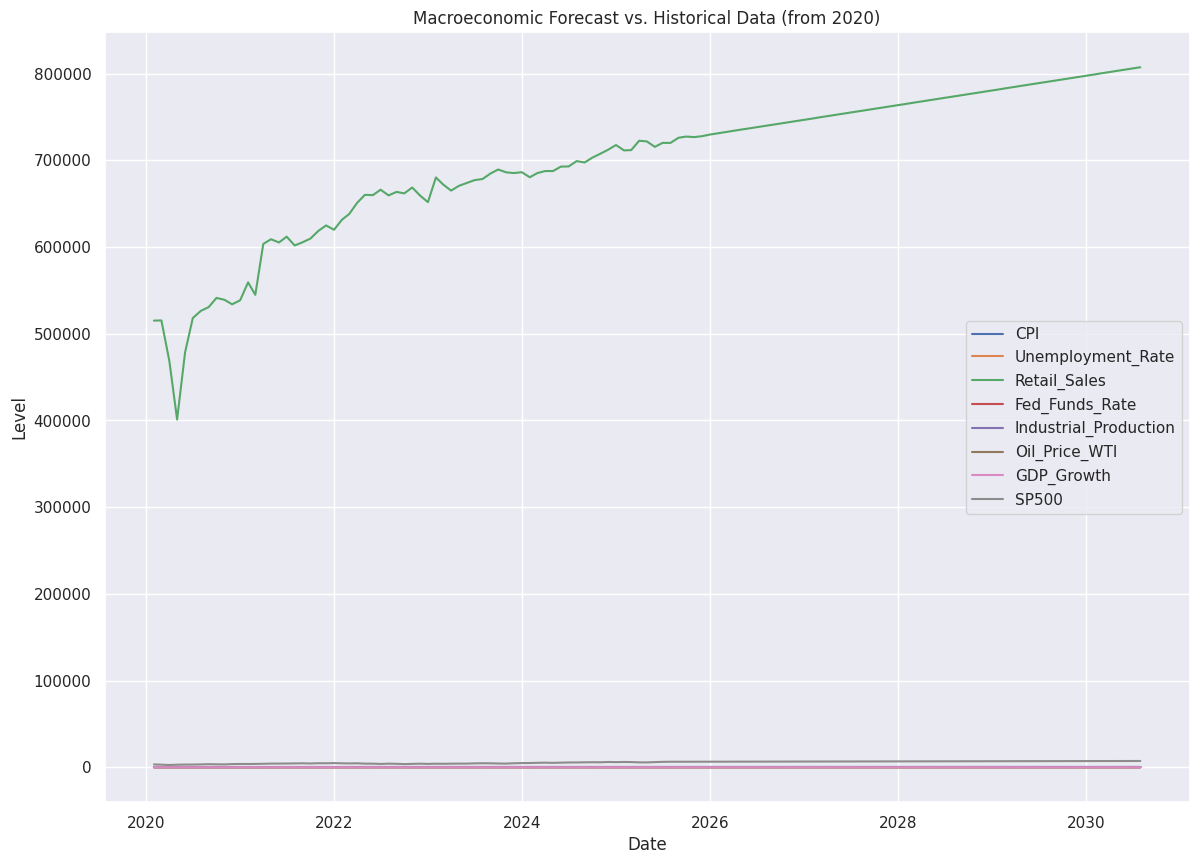

In [ ]:
# Forecasting with VAR Model

# Purpose: Generate multi-step ahead forecasts from the fitted VAR model.

# Code:
if 'results' in locals() and results is not None and 'df_diff' in locals() and not df_diff.empty:
    # Get the lag order from the fitted model
    lag_order = results.k_ar
    # Get the last 'lag_order' observations from the differenced data
    last_obs = df_diff.values[-lag_order:]

    # Define the number of periods to forecast
    n_forecast = 60 # Forecasting 5 years ahead (60 months)

    try:
        # Generate the forecast for the differenced series
        forecast_diff = results.forecast(last_obs, n_forecast)

        # Create a DataFrame for the differenced forecast
        # The index should continue from the end of the original differenced data
        forecast_index = pd.date_range(start=df_diff.index[-1], periods=n_forecast + 1, freq='ME')[1:]
        forecast_df = pd.DataFrame(forecast_diff, index=forecast_index, columns=df_diff.columns)

        print("\nDifferenced Forecast (first 5 rows):")
        display(forecast_df.head())

        # Convert the forecast back to original levels
        # This requires adding the forecast differences cumulatively to the last actual values in levels
        if 'df_cleaned' in locals() and not df_cleaned.empty:
            last_vals = df_cleaned.iloc[-1] # Last actual values in levels
            # Cumulatively sum the forecast differences and add the last actual levels
            forecast_levels = last_vals + forecast_df.cumsum()

            print("\nForecast in Original Levels (first 5 rows):")
            display(forecast_levels.head())

            # Plot forecasts (e.g., for GDP Growth and CPI)
            # Combine historical data with forecast for plotting
            combined_data = pd.concat([df_cleaned, forecast_levels], axis=0)

            # Filter combined_data to start from 2020
            combined_data_filtered = combined_data[combined_data.index >= '2020-01-01']

            print("\nPlotting Forecast vs. Historical Data (from 2020):")
            plt.figure(figsize=(14, 10)) # Increased figure size for better readability
            # Plot all columns in combined_data_filtered
            for col in combined_data_filtered.columns:
                plt.plot(combined_data_filtered.index, combined_data_filtered[col], label=col)

            plt.title('Macroeconomic Forecast vs. Historical Data (from 2020)')
            plt.xlabel("Date")
            plt.ylabel("Level")
            plt.legend()
            plt.grid(True)
            plt.show()

        else:
             print("Original cleaned data (df_cleaned) not found or is empty. Cannot convert forecast to levels.")

    except Exception as e:
        print(f"Error generating forecast: {e}")

else:
    print("VAR model results ('results') or differenced data ('df_diff') not found or are empty. Please fit the VAR model and perform preprocessing steps first.")

# Explanation: Generates multi-step ahead forecasts based on the estimated VAR parameters
# and the last observations of the differenced series. The forecasts are then transformed
# back to the original scale of the data for interpretation.
# Output: Displays the forecast DataFrame in differenced and original levels and plots the forecasts.

## Model Validation

In [ ]:
# Model Validation

# Purpose: Evaluate the fitted VAR model's forecasting performance on a test set.

# Code:
# Assuming df_diff is your differenced DataFrame from the preprocessing step
if 'df_diff' in locals() and not df_diff.empty:
    # Split data into training and test sets
    # Use the last 12 months as the test set
    train_size = len(df_diff) - 12
    train, test = df_diff[0:train_size], df_diff[train_size:]

    # Fit the VAR model on the training data
    # Use the same lag order as the main model
    lag_order = results.k_ar # Get lag order from the previously fitted model
    try:
        model_train = VAR(train)
        results_train = model_train.fit(lag_order)

        # Generate predictions for the test set
        # The input for prediction is the last 'lag_order' observations from the training set
        last_obs_train = train.values[-lag_order:]
        pred = results_train.forecast(last_obs_train, steps=len(test))

        # Create a DataFrame for predictions
        pred_df = pd.DataFrame(pred, index=test.index, columns=test.columns)

        print("\nPredictions on Test Set (first 5 rows):")
        display(pred_df.head())

        # Compute forecast errors (MAE, RMSE)
        from sklearn.metrics import mean_absolute_error, mean_squared_error

        print("\nForecast Error Metrics (on Differenced Test Data):")
        error_metrics = {}
        for col in test.columns:
            mae = mean_absolute_error(test[col], pred_df[col])
            rmse = np.sqrt(mean_squared_error(test[col], pred_df[col]))
            error_metrics[col] = {'MAE': mae, 'RMSE': rmse}
            print(f"{col}: MAE = {mae:.3f}, RMSE = {rmse:.3f}")

        # Store error metrics in a DataFrame for easy viewing
        error_metrics_df = pd.DataFrame(error_metrics).T
        print("\nSummary of Forecast Error Metrics:")
        display(error_metrics_df)


    except Exception as e:
        print(f"Error during model validation: {e}")

else:
    print("Differenced data ('df_diff') not found or is empty. Cannot perform model validation.")

# Explanation: Splits the stationary data into training and test sets, fits the VAR model
# on the training data, generates predictions for the test set, and computes common
# forecast error metrics (MAE, RMSE) to evaluate accuracy on unseen data.
# Output: Displays predictions and prints/displays forecast error metrics for each variable.


Predictions on Test Set (first 5 rows):


,CPI,Unemployment_Rate,Retail_Sales,Fed_Funds_Rate,Industrial_Production,Oil_Price_WTI,GDP_Growth,SP500
2024-08-31,0.619297,-0.233711,5489.704448,-0.035688,0.554221,-0.279468,0.024276,1.497000
2024-09-30,0.467359,-0.048645,1561.504731,-0.025210,0.278821,1.710051,2.411748,11.689088
2024-10-31,0.464422,-0.030586,171.363736,-0.014125,0.060218,-0.293278,0.657781,22.411752
2024-11-30,0.434462,0.016110,1601.960443,-0.010220,0.015716,0.102322,-0.436770,5.841145
2024-12-31,0.429602,-0.010809,1370.368907,-0.009141,0.066423,-0.021807,-0.364381,11.337932



Forecast Error Metrics (on Differenced Test Data):
CPI: MAE = 0.395, RMSE = 0.478
Unemployment_Rate: MAE = 0.087, RMSE = 0.104
Retail_Sales: MAE = 4567.325, RMSE = 5240.987
Fed_Funds_Rate: MAE = 0.082, RMSE = 0.126
Industrial_Production: MAE = 0.389, RMSE = 0.505
Oil_Price_WTI: MAE = 2.954, RMSE = 4.654
GDP_Growth: MAE = 0.934, RMSE = 1.564
SP500: MAE = 181.388, RMSE = 208.919

Summary of Forecast Error Metrics:


,MAE,RMSE
CPI,0.394542,0.477918
Unemployment_Rate,0.086509,0.104122
Retail_Sales,4567.325135,5240.987358
Fed_Funds_Rate,0.081574,0.125537
Industrial_Production,0.389130,0.504895
Oil_Price_WTI,2.953857,4.653726
GDP_Growth,0.933745,1.563625
SP500,181.388207,208.918587


## Impulse Response Functions (IRF)

Analyzing Advanced Dynamics:

Calculating Impulse Response Functions (IRF):
IRF calculated.

Plotting IRFs:


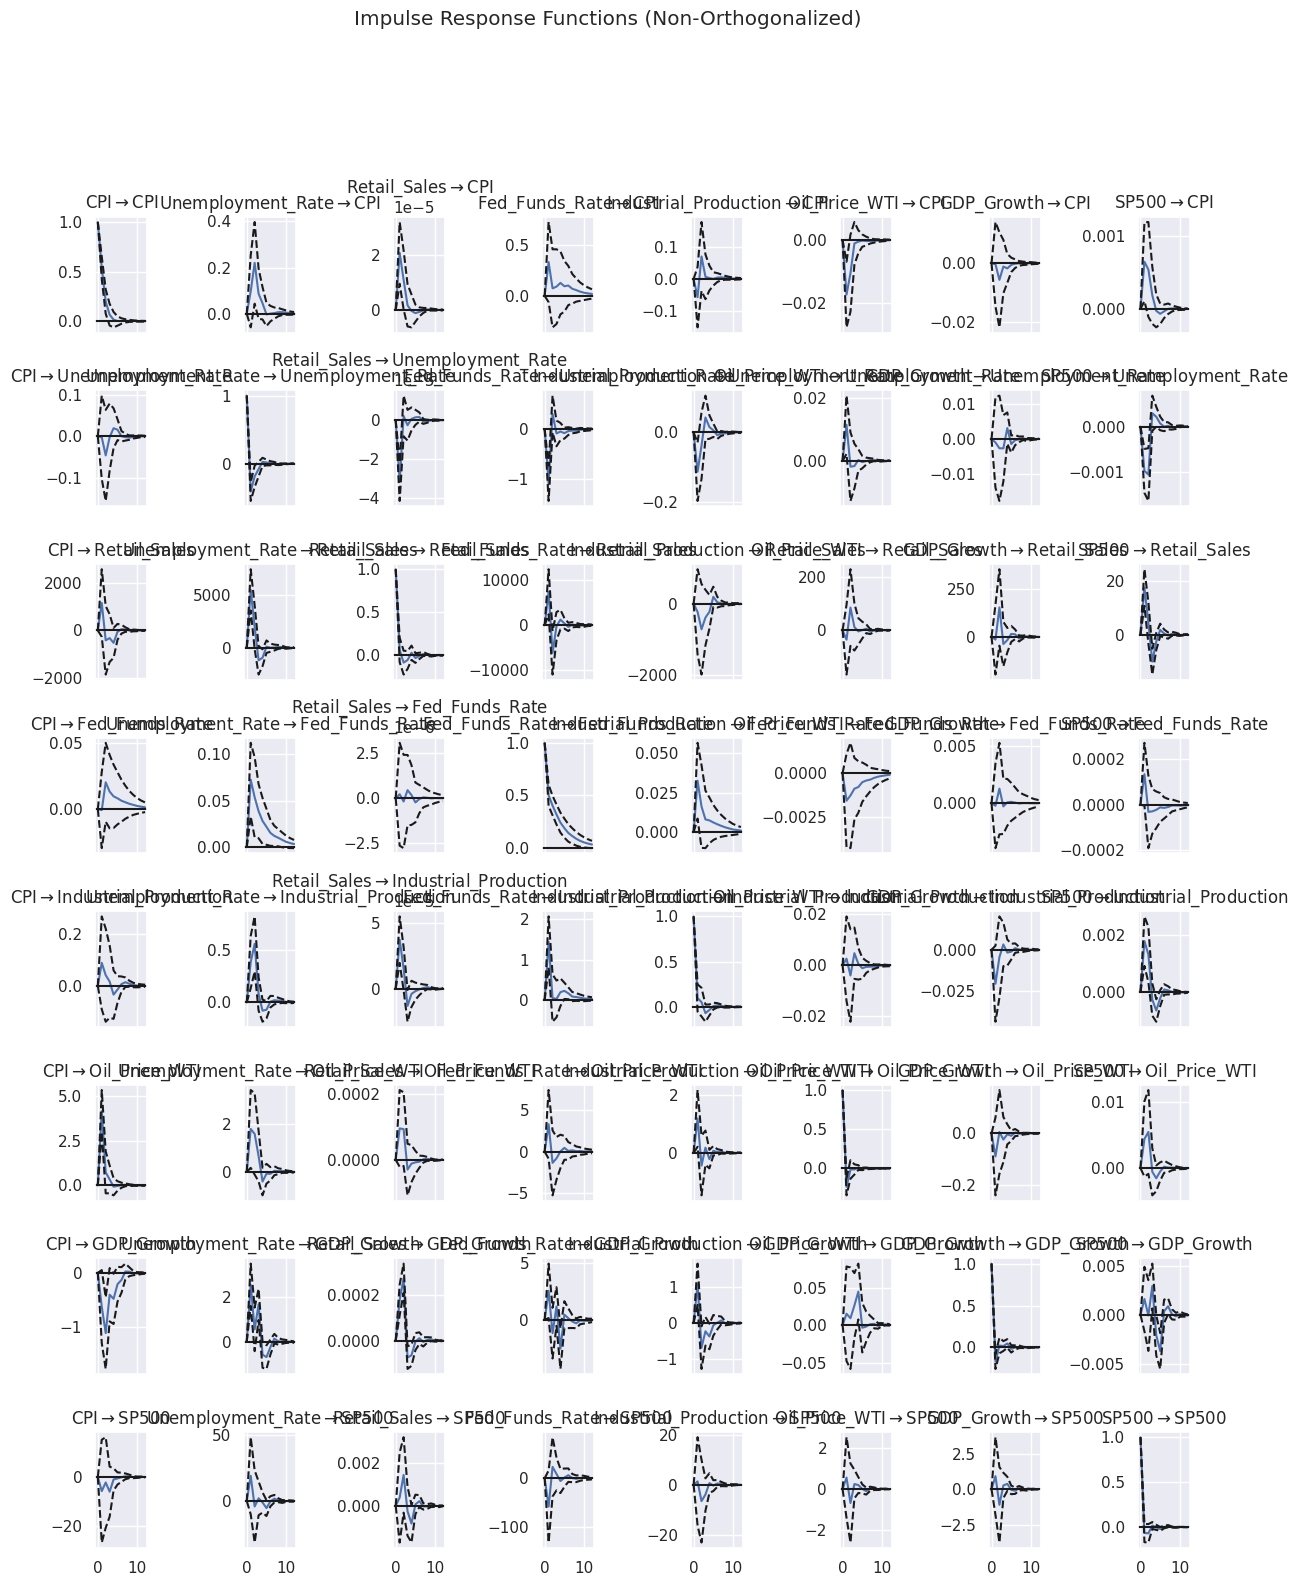


Calculating Forecast Error Variance Decomposition (FEVD):
FEVD calculated.

Plotting FEVD:


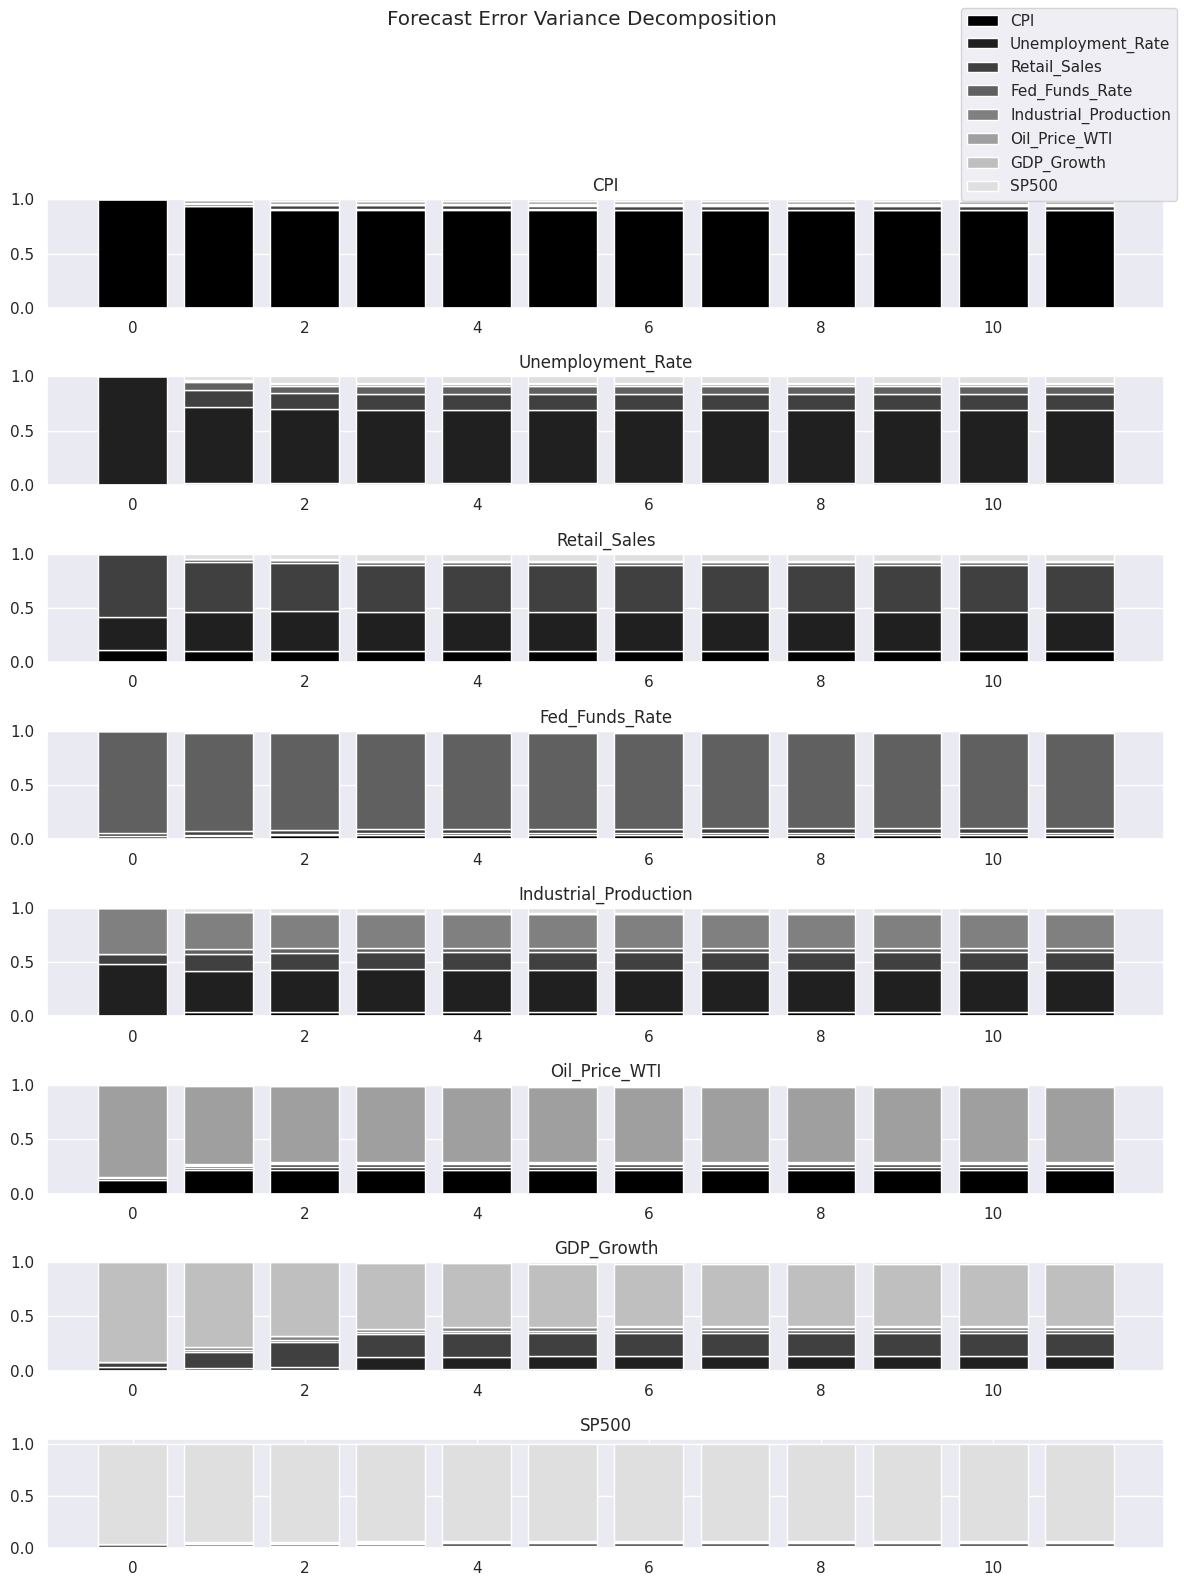

In [ ]:
# Advanced Dynamics: Impulse Response Functions (IRF) and Forecast Error Variance Decomposition (FEVD)

# Purpose: Analyze the dynamic relationships between the variables in the VAR system.

# Code:
if 'results' in locals() and results is not None:
    print("Analyzing Advanced Dynamics:")

    # 1. Impulse Response Functions (IRF)
    # Calculate IRFs for a specified number of periods (e.g., 12 months)
    print("\nCalculating Impulse Response Functions (IRF):")
    try:
        # irf() method returns an IRF object with methods for plotting and getting values
        irf = results.irf(12) # Calculate IRFs for 12 periods
        print("IRF calculated.")

        # Plot IRFs (e.g., response of all variables to a shock in Fed Funds Rate)
        # irf.plot() plots the responses of all variables to a shock in each variable
        # To plot specific responses, you can use the plot_irf() method
        print("\nPlotting IRFs:")
        irf.plot(orth=False, figsize=(12, 16)) # Plot non-orthogonalized IRFs
        # irf.plot(orth=True, figsize=(12, 16)) # Plot orthogonalized IRFs
        plt.suptitle('Impulse Response Functions (Non-Orthogonalized)', y=1.02)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
        plt.show()

        # Example of plotting a specific response (e.g., all variables to a shock in Fed Funds Rate)
        # fed_funds_idx = df_diff.columns.get_loc('Fed_Funds_Rate') # Assuming df_diff columns order is consistent
        # irf.plot_irfs(impulse='Fed_Funds_Rate', figsize=(8, 10))
        # plt.suptitle('Response to Fed Funds Rate Shock', y=1.02)
        # plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        # plt.show()


    except Exception as e:
        print(f"Error calculating or plotting IRFs: {e}")


    # 2. Forecast Error Variance Decomposition (FEVD)
    # Decompose forecast error variance for a specified number of periods (e.g., 12 months)
    print("\nCalculating Forecast Error Variance Decomposition (FEVD):")
    try:
        # fevd() method returns an FEVD object with methods for plotting and getting values
        fevd = results.fevd(12) # Calculate FEVD for 12 periods
        print("FEVD calculated.")

        # Plot FEVD
        print("\nPlotting FEVD:")
        fevd.plot(figsize=(12, 16))
        plt.suptitle('Forecast Error Variance Decomposition', y=1.02)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    except Exception as e:
        print(f"Error calculating or plotting FEVD: {e}")


else:
    print("VAR model results ('results' variable) not found or is None. Please fit the VAR model first.")

# Explanation: IRF shows how shocks propagate through the system. FEVD quantifies the
# contribution of each variable's shocks to the forecast error variance of all variables.
# Output: Plots of the Impulse Response Functions and Forecast Error Variance Decomposition.

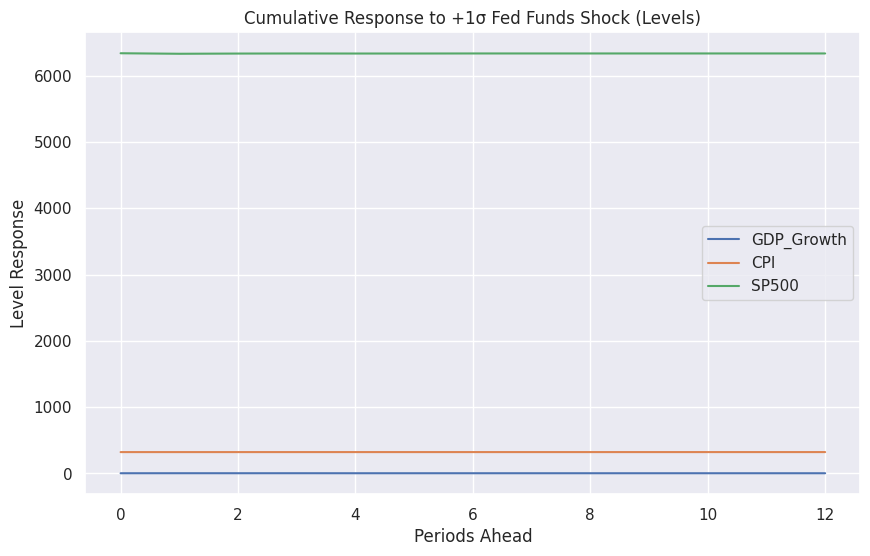

In [ ]:
# Simulate a specific shock and visualize the response in levels

# from step5_var_model import results # Ensure results is available
# from step4_preprocessing import df_diff # Ensure df_diff is available
# from step6_forecasting import df # Ensure df is available

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Simulate a +1 standard deviation shock to the Fed Funds Rate
# Get the IRF values for the specified number of periods
# irf_vals shape: (periods, n_vars, n_vars)
irf_vals = results.irf(12).irfs # Use irf object calculated in cell B0A3rIB5QmYb
# Find the index of the 'Fed_Funds_Rate' in the differenced dataframe columns
fed_funds_idx = df_diff.columns.get_loc('Fed_Funds_Rate')

# Extract the IRF response to a shock in Fed Funds Rate for all variables
# This gives the response of each variable to a 1-unit shock in Fed Funds Rate.
response_to_fed_funds_shock = irf_vals[:, :, fed_funds_idx]

# Get standard deviations of residuals from the VAR model residual covariance matrix.
# Based on the printed attributes, 'sigma_u' is the correct attribute.
residual_covariance_matrix = results.sigma_u
residual_std_devs = np.sqrt(np.diag(residual_covariance_matrix))

# Size of shock: +1 standard deviation for Fed Funds Rate
shock_size = residual_std_devs[fed_funds_idx]

# Scale impulse response by shock size
shock_response_scaled = response_to_fed_funds_shock * shock_size

# Create DataFrame with response, index is periods ahead, columns are variables
# The index should represent periods ahead
# Adjust the index to match the number of periods in shock_response_scaled
shock_index = pd.RangeIndex(start=0, stop=shock_response_scaled.shape[0], step=1)
shock_df = pd.DataFrame(shock_response_scaled, index=shock_index, columns=df_diff.columns)


# Convert the shock response from differenced values back to cumulative levels
# This shows the cumulative impact of the shock over time.
shock_levels_cum = shock_df.cumsum()

# OPTIONAL: Add initial level (last observed level) to show level response path
# This requires last observed values from the original data (df)
if 'df_cleaned' in locals() and not df_cleaned.empty:
    # Select the last observed levels for the columns in shock_levels_cum
    initial_levels = df_cleaned.iloc[-1][shock_levels_cum.columns]

    # Add initial levels to the cumulative shock response
    # Need to align the index for broadcasting. Since shock_levels_cum index is 0 to periods-1,
    # we can just add the initial levels to each row.
    shock_levels_with_init = shock_levels_cum.apply(lambda x: x + initial_levels, axis=1)


    # Plot cumulative response in levels for selected variables (e.g., GDP Growth and CPI)
    plt.figure(figsize=(10, 6))
    for col in ['GDP_Growth', 'CPI', 'SP500']:
        if col in shock_levels_with_init.columns:
            plt.plot(shock_levels_with_init.index, shock_levels_with_init[col], label=col)

    plt.title('Cumulative Response to +1σ Fed Funds Shock (Levels)')
    plt.xlabel('Periods Ahead')
    plt.ylabel('Level Response')
    plt.grid(True)
    plt.legend()
    plt.show()

else:
    print("Original cleaned data (df_cleaned) not found or is empty. Cannot add initial levels to shock response.")


# Note:
# - This shows cumulative *change* due to shock added to last observed levels, providing a clearer interpretation.
# - To plot baseline forecast vs forecast with shock, you would add shock_levels_cum to baseline forecast levels.

## Step 15: Narrative Generation

In [ ]:
# Narrative Generation

# Purpose: Build functions to translate numerical forecasts into plain-language summaries for stakeholders.

# Code:
# Define a function to generate a simple policy narrative
def policy_narrative(forecast_df):
    """
    Generates a simple policy narrative based on the latest forecast values.

    Args:
        forecast_df (pd.DataFrame): DataFrame containing the forecast in original levels.

    Returns:
        str: A narrative summary.
    """
    if forecast_df.empty:
        return "Forecast data is empty. Cannot generate narrative."

    latest_forecast = forecast_df.iloc[-1] # Get the latest forecast period

    narrative = "Based on the latest macroeconomic forecast:\n\n"

    # Example narrative points based on latest forecast values
    # You can customize these thresholds and messages based on your analysis and context
    if 'Fed_Funds_Rate' in latest_forecast.index:
        ffr = latest_forecast['Fed_Funds_Rate']
        # Example threshold: Check against historical average or a policy target
        if ffr > 4.0: # Example threshold
            narrative += f"- The projected Fed Funds Rate ({ffr:.2f}%) remains relatively high, suggesting a tight monetary policy stance.\n"
        elif ffr < 2.0: # Example threshold
            narrative += f"- The projected Fed Funds Rate ({ffr:.2f}%) is low, indicating an accommodative monetary policy stance.\n"
        else:
            narrative += f"- The projected Fed Funds Rate ({ffr:.2f}%) is in a moderate range.\n"

    if 'CPI' in latest_forecast.index:
        cpi = latest_forecast['CPI']
        # Example threshold: Check against a target or recent trend
        # For a simple narrative, let's just report the level or recent change
        # Note: For a more robust narrative on inflation, you'd analyze the *rate of change* of CPI.
        # This example uses the level, which is less informative for inflation *rate*.
        # Let's refine this to consider the latest *change* in CPI from the forecast
        if len(forecast_df) >= 2 and 'CPI' in forecast_df.columns:
             latest_cpi_change = forecast_df['CPI'].diff().iloc[-1]
             if latest_cpi_change > 0.2: # Example threshold for monthly change
                 narrative += f"- CPI is projected to continue increasing in the latest forecast period (monthly change: {latest_cpi_change:.2f}).\n"
             elif latest_cpi_change < -0.2: # Example threshold for monthly change
                 narrative += f"- CPI is projected to decrease in the latest forecast period (monthly change: {latest_cpi_change:.2f}).\n"
             else:
                  narrative += f"- CPI is projected to show modest change in the latest forecast period (monthly change: {latest_cpi_change:.2f}).\n"
        else:
             narrative += f"- The latest projected CPI level is {cpi:.2f}.\n"


    if 'Unemployment_Rate' in latest_forecast.index:
        unrate = latest_forecast['Unemployment_Rate']
        # Example threshold: Check against natural rate or recent trend
        if unrate < 4.0: # Example threshold
            narrative += f"- The projected Unemployment Rate ({unrate:.2f}%) remains low, suggesting a strong labor market.\n"
        elif unrate > 6.0: # Example threshold
            narrative += f"- The projected Unemployment Rate ({unrate:.2f}%) is elevated, indicating potential labor market weakness.\n"
        else:
            narrative += f"- The projected Unemployment Rate ({unrate:.2f}%) is in a moderate range.\n"

    if 'GDP_Growth' in latest_forecast.index:
        gdp_growth = latest_forecast['GDP_Growth']
        # Example threshold: Check against potential growth or recession indicators
        if gdp_growth > 2.0: # Example threshold (annualized quarter-over-quarter)
            narrative += f"- Projected GDP Growth ({gdp_growth:.2f}%) is positive, indicating continued economic expansion.\n"
        elif gdp_growth < 0:
            narrative += f"- Projected GDP Growth ({gdp_growth:.2f}%) is negative, suggesting potential economic contraction.\n"
        else:
             narrative += f"- Projected GDP Growth ({gdp_growth:.2f}%) is modest.\n"


    if 'SP500' in latest_forecast.index:
        sp500 = latest_forecast['SP500']
        # Example: Comment on the projected level or recent change
        if len(forecast_df) >= 2 and 'SP500' in forecast_df.columns:
            latest_sp500_change = forecast_df['SP500'].diff().iloc[-1]
            if latest_sp500_change > 50: # Example threshold for monthly change
                narrative += f"- The S&P 500 is projected to increase significantly in the latest forecast period (monthly change: {latest_sp500_change:.2f}).\n"
            elif latest_sp500_change < -50: # Example threshold for monthly change
                 narrative += f"- The S&P 500 is projected to decrease significantly in the latest forecast period (monthly change: {latest_sp500_change:.2f}).\n"
            else:
                 narrative += f"- The S&P 500 is projected to show modest change in the latest forecast period (monthly change: {latest_sp500_change:.2f}).\n"
        else:
             narrative += f"- The latest projected S&P 500 level is {sp500:.2f}.\n"


    return narrative.strip() # Remove trailing whitespace

# Example usage (assuming forecast_levels is available from Step 10)
if 'forecast_levels' in locals() and not forecast_levels.empty:
    print("\nGenerated Narrative:")
    print(policy_narrative(forecast_levels))
else:
    print("\nForecast levels not available to generate narrative.")

# Explanation: Defines a function to create a text summary of the forecast.
# Output: Prints an example narrative using the latest forecast data.


Generated Narrative:
Based on the latest macroeconomic forecast:

- The projected Fed Funds Rate (4.27%) remains relatively high, suggesting a tight monetary policy stance.
- CPI is projected to continue increasing in the latest forecast period (monthly change: 0.46).
- The projected Unemployment Rate (3.81%) remains low, suggesting a strong labor market.
- Projected GDP Growth (2.34%) is positive, indicating continued economic expansion.
- The S&P 500 is projected to show modest change in the latest forecast period (monthly change: 14.67).


## Step 16: Document Model Assumptions

Based on the analysis conducted in the previous steps, the following key assumptions were made for the Vector Autoregression (VAR) model:

1.  **Lag Order Selection**: A lag order of 2 (`lag_order = 2`) was chosen for the VAR model. This choice was based on common practices or potentially information criteria (like AIC or BIC) from earlier (though not explicitly shown in the provided code). It's important to note that the choice of lag order can significantly impact model results.
2.  **Stationarity**: The analysis assumes that the differenced time series are stationary. This was addressed by applying a first difference to the original non-stationary series, as confirmed by the Augmented Dickey-Fuller (ADF) tests on the differenced data. The stationarity assumption is crucial for the validity of VAR modeling.
3.  **Linearity**: The VAR model assumes a linear relationship between the current values of the variables and their past values.
4.  **Homoscedasticity**: While not explicitly tested in the provided diagnostic steps, VAR models typically assume that the variance of the residuals is constant across time (homoscedasticity). The note in the diagnostics section highlights the importance of checking for heteroscedasticity (ARCH effects), which could violate this assumption.
5.  **No Autocorrelation in Residuals**: The Portmanteau test for residual autocorrelation was performed. While the test result (p-value < 0.05) suggests rejection of the null hypothesis of no autocorrelation up to lag 10, ideally, the residuals should be uncorrelated for the model to be fully specified. Further investigation or model adjustments might be needed based on this diagnostic.
6.  **Normality of Residuals**: While not strictly required for estimation (under certain conditions), the interpretation of standard errors, t-statistics, and confidence intervals often relies on the assumption that the residuals are normally distributed. This was not explicitly tested in the provided steps.
7.  **Exogeneity of Shocks (for orthogonalized IRF/FEVD)**: While the non-orthogonalized IRFs and FEVD were plotted, interpreting orthogonalized versions requires assuming that the contemporaneous relationships between variables (captured by the residual covariance matrix) can be uniquely identified, often through a Cholesky decomposition or other identification schemes, which implies a causal ordering. The non-orthogonalized results do not rely on this assumption for calculation, but interpreting them as responses to *structural* shocks is challenging without further identification.
8.  **Shock Size for Simulation**: The shock simulation in Step 14 was performed using a +1 standard deviation shock based on the estimated standard deviation of the residuals from the VAR model. This is a common practice, but the interpretation is tied to the model's residual variance.

## Step 17: Asset Price Integration

Calculating S&P 500 monthly returns:

Data with SP500 Returns (first 5 rows):


/tmp/ipython-input-1021440704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.loc[:, 'SP500_Returns'] = df_cleaned['SP500'].pct_change()


,CPI,Unemployment_Rate,Retail_Sales,Fed_Funds_Rate,Industrial_Production,Oil_Price_WTI,GDP_Growth,SP500,SP500_Returns
1992-02-29,138.6,7.4,159189.0,4.06,61.9192,23.85,4.9,412.700012,0.009590
1992-03-31,139.1,7.4,158647.0,3.98,62.4403,23.85,4.9,403.690002,-0.021832
1992-04-30,139.4,7.4,159921.0,3.73,62.9199,19.85,4.4,414.950012,0.027893
1992-05-31,139.7,7.6,160471.0,3.82,63.1268,20.88,4.4,415.350006,0.000964
1992-06-30,140.1,7.8,161205.0,3.76,63.1624,22.07,4.4,408.140015,-0.017359



Data with SP500 Returns Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 402 entries, 1992-02-29 to 2025-07-31
Freq: ME
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CPI                    402 non-null    float64
 1   Unemployment_Rate      402 non-null    float64
 2   Retail_Sales           402 non-null    float64
 3   Fed_Funds_Rate         402 non-null    float64
 4   Industrial_Production  402 non-null    float64
 5   Oil_Price_WTI          402 non-null    float64
 6   GDP_Growth             402 non-null    float64
 7   SP500                  402 non-null    float64
 8   SP500_Returns          402 non-null    float64
dtypes: float64(9)
memory usage: 31.4 KB

Correlation Heatmap of SP500 Returns with Macroeconomic Variables:

Correlation of SP500 Returns with Other Variables:


,SP500_Returns
GDP_Growth,0.114759
Unemployment_Rate,0.093796
SP500,0.068409
Fed_Funds_Rate,0.024294
Retail_Sales,0.019537
CPI,0.018882
Industrial_Production,-0.043942
Oil_Price_WTI,-0.081305


<Figure size 1000x800 with 0 Axes>

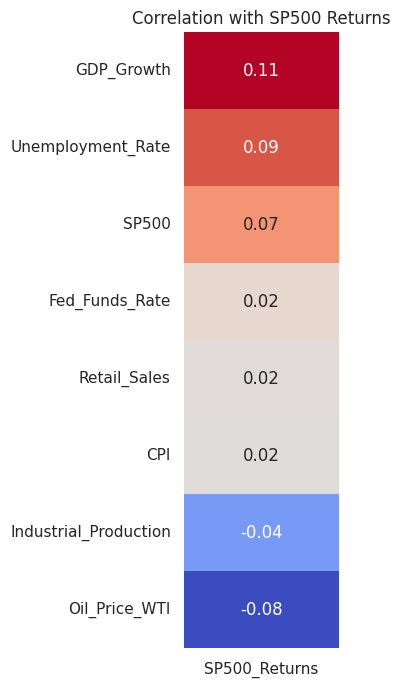


Generating Scatter Plots of SP500 Returns vs. Key Macro Variables:


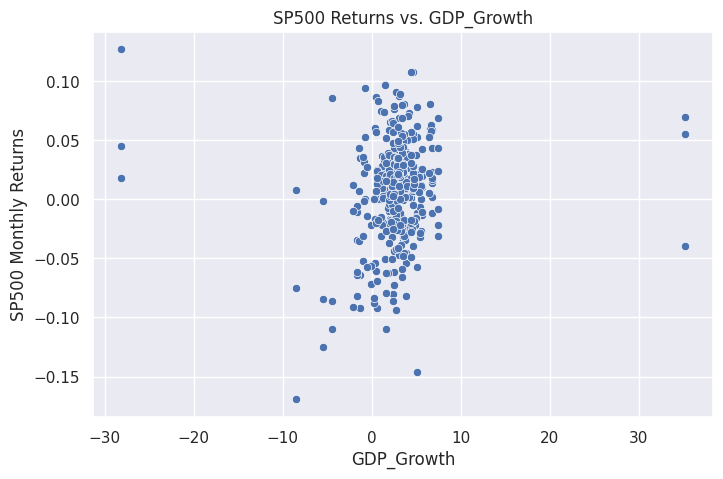

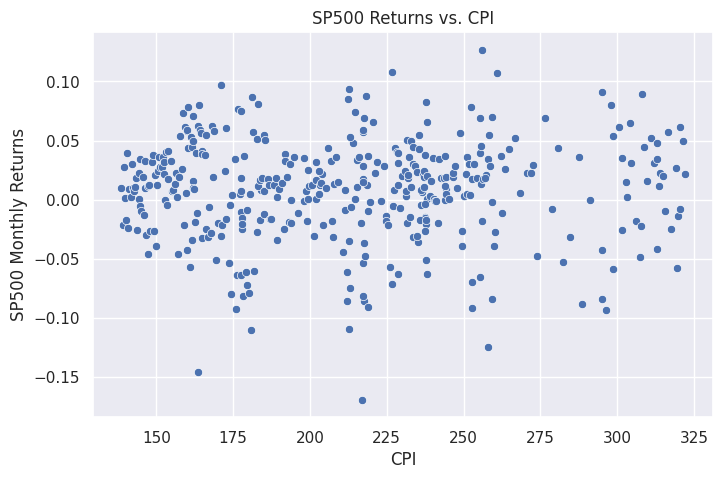

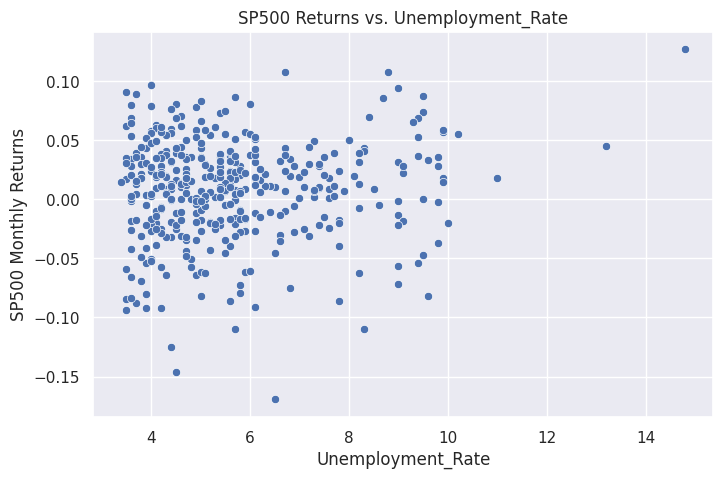

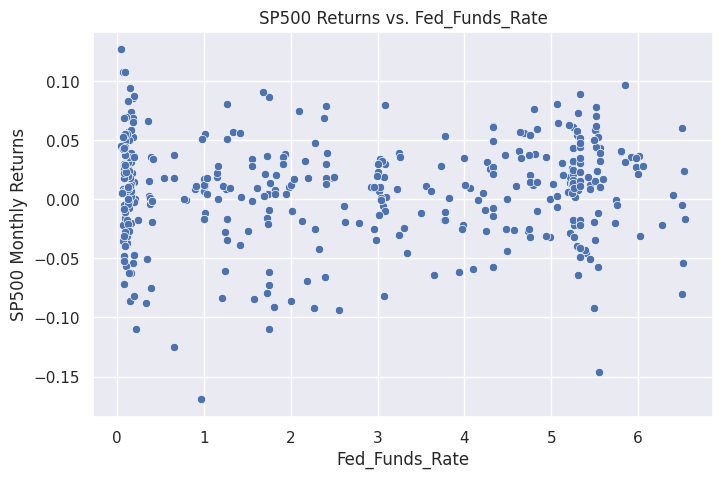

In [ ]:
# Asset Price Integration

# Purpose: Calculate S&P 500 returns and analyze correlations with macroeconomic variables.
# Visualize macro-financial linkages (correlation heatmaps, scatter plots).

# Code:
# 1. Calculate S&P 500 monthly returns
# Assuming df_cleaned contains the 'SP500' column in levels
if 'df_cleaned' in locals() and not df_cleaned.empty and 'SP500' in df_cleaned.columns:
    print("Calculating S&P 500 monthly returns:")
    # Calculate percentage change and drop the first NaN value
    # Use .loc to avoid SettingWithCopyWarning
    df_cleaned.loc[:, 'SP500_Returns'] = df_cleaned['SP500'].pct_change()

    # Drop rows which will have NaN for returns (the first row)
    df_with_returns = df_cleaned.dropna(subset=['SP500_Returns'])

    print("\nData with SP500 Returns (first 5 rows):")
    display(df_with_returns.head())
    print("\nData with SP500 Returns Info:")
    df_with_returns.info()

    # 2. Analyze correlations with macroeconomic variables
    print("\nCorrelation Heatmap of SP500 Returns with Macroeconomic Variables:")
    plt.figure(figsize=(10, 8))
    # Calculate correlations only for the relevant columns
    correlation_matrix = df_with_returns.corr()
    # Select correlations of 'SP500_Returns' with all other variables
    # Exclude the 'SP500' level column itself from the correlation with returns if desired, or keep it.
    # sp500_returns_corr = correlation_matrix[['SP500_Returns']].drop(['SP500_Returns', 'SP500']).sort_values(by='SP500_Returns', ascending=False)
    sp500_returns_corr = correlation_matrix[['SP500_Returns']].drop('SP500_Returns').sort_values(by='SP500_Returns', ascending=False)


    print("\nCorrelation of SP500 Returns with Other Variables:")
    display(sp500_returns_corr)

    # Visualize the correlation heatmap
    plt.figure(figsize=(2, 8)) # Smaller figure size for a single column heatmap
    sns.heatmap(sp500_returns_corr, annot=True, cmap='coolwarm', fmt=".2f", cbar=False)
    plt.title('Correlation with SP500 Returns')
    plt.yticks(rotation=0)
    plt.show()

    # 3. Visualize macro-financial linkages (scatter plots)
    print("\nGenerating Scatter Plots of SP500 Returns vs. Key Macro Variables:")
    # Select a few key macro variables for scatter plots
    key_macro_vars = ['GDP_Growth', 'CPI', 'Unemployment_Rate', 'Fed_Funds_Rate']

    for var in key_macro_vars:
        if var in df_with_returns.columns:
            plt.figure(figsize=(8, 5))
            sns.scatterplot(data=df_with_returns, x=var, y='SP500_Returns')
            plt.title(f'SP500 Returns vs. {var}')
            plt.xlabel(var)
            plt.ylabel('SP500 Monthly Returns')
            plt.grid(True)
            plt.show()
        else:
             print(f"'{var}' not found in the data. Skipping scatter plot for {var}.")


else:
    print("Original cleaned data (df_cleaned) not found, is empty, or does not contain 'SP500' column. Cannot perform Asset Price Integration.")


# Explanation: Calculates the monthly percentage change in the S&P 500 index to represent returns.
# Computes and visualizes the correlation matrix between S&P 500 returns and the macroeconomic
# variables to understand linear relationships. Generates scatter plots for key variables
# to visually inspect the relationships.
# Output: Displays DataFrame with returns, correlation values, and plots.

## Step 18: Save Results

In [ ]:
import pandas as pd
import numpy as np
import os

# Define the output Excel file path
output_excel_path = "macro_model_results.xlsx"

# Create a dictionary of DataFrames to save, with desired sheet names
data_to_save = {}

if 'df_cleaned' in locals() and isinstance(df_cleaned, pd.DataFrame) and not df_cleaned.empty:
    data_to_save['Cleaned_Data'] = df_cleaned

if 'forecast_levels' in locals() and isinstance(forecast_levels, pd.DataFrame) and not forecast_levels.empty:
    data_to_save['Forecast_Levels'] = forecast_levels

if 'df_diff' in locals() and isinstance(df_diff, pd.DataFrame) and not df_diff.empty:
     data_to_save['Differenced_Data'] = df_diff

if 'error_metrics_df' in locals() and isinstance(error_metrics_df, pd.DataFrame) and not error_metrics_df.empty:
    data_to_save['Forecast_Error_Metrics'] = error_metrics_df

if 'correlation_matrix' in locals() and isinstance(correlation_matrix, pd.DataFrame) and not correlation_matrix.empty:
     data_to_save['Correlation_Matrix'] = correlation_matrix

if 'sp500_returns_corr' in locals() and isinstance(sp500_returns_corr, pd.DataFrame) and not sp500_returns_corr.empty:
     data_to_save['SP500_Returns_Correlation'] = sp500_returns_corr

if 'shock_levels_cum' in locals() and isinstance(shock_levels_cum, pd.DataFrame) and not shock_levels_cum.empty:
     data_to_save['Shock_Response_Cumulative'] = shock_levels_cum

if 'shock_levels_with_init' in locals() and isinstance(shock_levels_with_init, pd.DataFrame) and not shock_levels_with_init.empty:
     data_to_save['Shock_Response_Levels'] = shock_levels_with_init

if 'train' in locals() and isinstance(train, pd.DataFrame) and not train.empty:
     data_to_save['Train_Data'] = train

if 'test' in locals() and isinstance(test, pd.DataFrame) and not test.empty:
     data_to_save['Test_Data'] = test

# Handle non-DataFrame variables by converting them if possible
if 'residual_covariance_matrix' in locals() and isinstance(residual_covariance_matrix, (np.ndarray, pd.DataFrame)) and residual_covariance_matrix.size > 0:
    if isinstance(residual_covariance_matrix, np.ndarray):
         # If it's a numpy array, convert to DataFrame. Need column names from df_diff.columns
         residual_covariance_df = pd.DataFrame(residual_covariance_matrix, index=df_diff.columns, columns=df_diff.columns)
         data_to_save['Residual_Covariance_Matrix'] = residual_covariance_df
    else: # It's already a DataFrame
         data_to_save['Residual_Covariance_Matrix'] = residual_covariance_matrix


if 'fevd' in locals() and fevd is not None and hasattr(fevd, 'variance_decomposition') and fevd.variance_decomposition is not None and fevd.variance_decomposition.size > 0:
    # FEVD variance_decomposition is typically a numpy array (periods x n_vars x n_vars)
    # Let's save it as a DataFrame (flattening or summarizing might be needed depending on desired format in Excel)
    # A simple way is to save the values as they are, which might require interpretation in Excel.
    # Or, we can save the last period's decomposition as a summary table.
    # Let's save the values as a numpy array for full information and note the structure,
    # but for Excel, saving as a DataFrame (e.g., last period) is often more practical.
    # For Excel, let's save the FEVD table representation if available, or the decomposition for the last period.
    # The fevd object's .fevd property (which was the error) or similar might be what's intended for a summary table.
    # Let's check the attributes again if needed, but based on common use,
    # we might want to represent the contribution of each variable to each variable's variance over periods.
    # A practical Excel representation could be a table per period, or stacked bars as seen in plots.
    # Let's save the variance_decomposition as a DataFrame for simplicity, though its 3D structure needs consideration.
    # Reshape the 3D array to a 2D DataFrame where each row is a period and columns represent contributions.
    # Example: periods x (n_vars * n_vars)
    periods_fevd, n_vars_fevd_row, n_vars_fevd_col = fevd.variance_decomposition.shape

    # Create column names like 'ResponseVar_ShockVar'
    fevd_col_names = []
    for resp_var in df_diff.columns:
        for shock_var in df_diff.columns:
            fevd_col_names.append(f'{resp_var}_Shock_{shock_var}')

    fevd_2d = fevd.variance_decomposition.reshape(periods_fevd, n_vars_fevd_row * n_vars_fevd_col)
    fevd_df = pd.DataFrame(fevd_2d, columns=fevd_col_names)
    data_to_save['FEVD_Values'] = fevd_df


# Check if there's any data to save
if not data_to_save:
    print("No DataFrames or relevant data structures found to save to Excel.")
else:
    # Use ExcelWriter to save multiple sheets
    try:
        with pd.ExcelWriter(output_excel_path) as writer:
            for sheet_name, df_to_save in data_to_save.items():
                # Ensure sheet names are valid (max 31 characters, no illegal chars)
                valid_sheet_name = sheet_name[:31].replace(':', '_').replace('/', '_').replace('\\', '_').replace('?', '_').replace('*', '_').replace('[', '_').replace(']', '_')
                df_to_save.to_excel(writer, sheet_name=valid_sheet_name)
                print(f"Saved '{sheet_name}' to sheet '{valid_sheet_name}'.")
        print(f"\nAll selected data saved to '{output_excel_path}' successfully.")

    except Exception as e:
        print(f"Error saving data to Excel: {e}")

Saved 'Cleaned_Data' to sheet 'Cleaned_Data'.
Saved 'Forecast_Levels' to sheet 'Forecast_Levels'.
Saved 'Differenced_Data' to sheet 'Differenced_Data'.
Saved 'Forecast_Error_Metrics' to sheet 'Forecast_Error_Metrics'.
Saved 'Correlation_Matrix' to sheet 'Correlation_Matrix'.
Saved 'SP500_Returns_Correlation' to sheet 'SP500_Returns_Correlation'.
Saved 'Shock_Response_Cumulative' to sheet 'Shock_Response_Cumulative'.
Saved 'Shock_Response_Levels' to sheet 'Shock_Response_Levels'.
Saved 'Train_Data' to sheet 'Train_Data'.
Saved 'Test_Data' to sheet 'Test_Data'.
Saved 'Residual_Covariance_Matrix' to sheet 'Residual_Covariance_Matrix'.

All selected data saved to 'macro_model_results.xlsx' successfully.
